In [8]:
import matplotlib.pyplot as plt
from erddapClient import ERDDAP_Griddap
from netCDF4 import Dataset
from matplotlib import colormaps
from pathlib import Path
import numpy as np
from pycurrents.file.binfile_n import BinfileSet
import xarray as xr
import pandas as pd

def arrayrbins(files):
    mat = list()
    for i in files:
        tmp = BinfileSet(str(i))
        mat.append(tmp.array)
    mat = np.vstack(mat)
    return(mat) 

def readrbins(pth, sensor, tag):
    tag = "*" + tag + "*.rbin"
    files = sorted(Path(pth+sensor+"/").glob(tag))
    mat = arrayrbins(files)

    #cols = BinfileSet(str(files[0])).columns
    mat = np.array(mat) #, dtype=cols)
    return(mat)

# get gps location
sea = readrbins(pth ='/mnt/revelle-data/RR2407/adcp_uhdas/RR2407/rbin/', sensor = 'seapath380', tag = 'gps')
gyro = readrbins(pth ='/mnt/revelle-data/RR2407/adcp_uhdas/RR2407/rbin/', sensor = 'gyro', tag = 'hdg')

# Global Ocean Colour (Copernicus-GlobColour), Bio-Geo-Chemical, L4 (monthly and interpolated) from Satellite Observations (Near Real Time)
file_id = Dataset('/home/jamie/projects/rogerrevelle/data/cmems_obs-oc_glo_bgc-plankton_nrt_l4-gapfree-multi-4km_P1D_1718025779968.nc')
ras = file_id.variables["CHL"][:]
lat = file_id.variables["latitude"][:]
lon = file_id.variables["longitude"][:]
file_id.close()

# Sea-Surface Temperature, NOAA Geo-polar Blended Analysis Day+Night, GHRSST, Near Real-Time, Global 5km, 2019-Present, Daily 
file_id = Dataset('/home/jamie/projects/rogerrevelle/data/noaacwBLENDEDsstDNDaily_e5b2_b4c7_9276_U1717797277907.nc')
mask = file_id.variables["mask"][:]
lat_m = file_id.variables["latitude"][:]
lon_m = file_id.variables["longitude"][:]
file_id.close()

# convert to xarray. 
ras = xr.DataArray(ras[0,:,:], 
                       coords={'x': lat, 'y':lon}, 
                       dims=["x", "y"])

mask = xr.DataArray(mask[0,:,:], 
                       coords={'x': lat_m, 'y':lon_m}, 
                       dims=["x", "y"])
mask = mask.where(mask.values != 1)

# fudging the nubers to get the colormap nice. 
ras_c = ras.clip(min=0, max=2.5, keep_attrs=False)
ras_f = ras.clip(min=0, max=2, keep_attrs=True)
ras_f = ras_f.fillna(np.nanmax(ras_f.values))

# PIES locations
swot_pos = np.column_stack(([-74.3666, -74.5339, -74.1932, -74.6728, -74.3657, -74.2781], 
                           [36.2333, 35.9997, 36.0069, 36.0001, 36.0012, 35.7561]))
swot_pos = np.array(swot_pos)
pioneer_pos = np.column_stack(([-74.705, -74.7633], [36.050, 35.700]))
pioneer_pos = np.array(pioneer_pos)

waypoints = np.column_stack(([-74.3666, -71.5, -71.0, -70.67], [36.2333, 39.5, 39.5, 41.527]))
waypoints = np.array(waypoints)

# pull out most regent heading and convert to radians. 
theta = gyro[-1,1] *(np.pi/180) # to radians
sea = sea[0::500]
u0 = sea[:, 2]
v0 = sea[:, 3]
s = sea.shape
pos = np.array([u0, v0]).T
#prev_pos = sea[-10:-1]

# grab last 10 positions. 
prev_pos = sea[-1000:-1]

ValueError: need at least one array to concatenate

In [364]:
xbt = np.genfromtxt('../data/XBT_positions.csv', delimiter=',')
def findframe(gps, point, eyballit):
    A = gps[:,0] > point[0] - eyballit
    B = gps[:,0] < point[0] + eyballit
    C = gps[:,1] > point[1] - eyballit
    D = gps[:,1] < point[1] + eyballit
    a = np.logical_and(A , B)
    b = np.logical_and(C , D)
    c = np.logical_and(a , b)
    idx = np.where(c)
    try:
        frame = np.min(idx)
        return(frame)
    except:
        return 9999
    

In [415]:
import pandas as pd
xbt = pd.read_csv('../data/XBT.csv')
ctd = pd.read_csv('../data/CTD.csv')
pies = pd.read_csv('../data/CPIES.csv')
drift = pd.read_csv('../data/DRIFTER.csv')

ctd = np.array(ctd[["Longitude", "Latitude"]])
xbt = np.array(xbt[["Longitude", "Latitude"]])
pies = np.array(pies[["Longitude", "Latitude"]])
drift = np.array(drift[["Longitude", "Latitude"]])

In [5]:
sea = readrbins(pth ='../data/rbins/', sensor = 'seapath380', tag = 'gps')

In [12]:
xbt = pd.read_csv('../data/eventlog/XBT.csv')


In [13]:
xbt.shape

(17, 19)

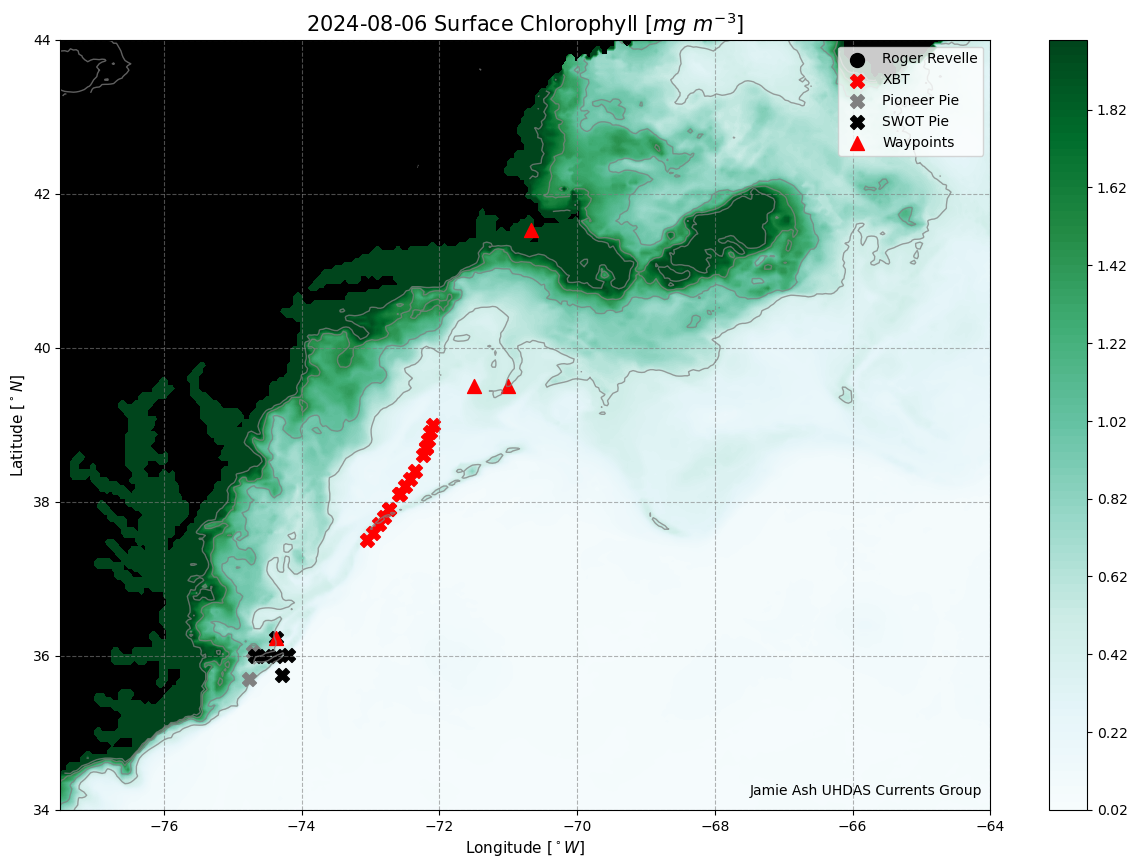

In [432]:
# ------------------------------------------------------------------------------------------------------------
# Plot the data. 
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 10))
ax1.contour(ras_c.y, ras_c.x, ras_c[:, :], 5, linewidths = 1, alpha = 0.75, colors = "grey")
c = ax1.contourf(ras_f.y, ras_f.x, ras_f[:, :], 100, cmap = "BuGn")
cbar = fig.colorbar(c)
ax1.contourf(mask.y, mask.x, mask[:,:], 1, colors = "black")

ax1.grid(color = "grey", linestyle = '--', alpha = 0.6)# visible=None)
ax1.scatter(pos[2], pos[3], s = 100, color = "black", label='Roger Revelle')
ax1.scatter(xbt[:,0], xbt[:,1], color = "red", marker = 'X', s = 100, label='XBT')
ax1.scatter(pioneer_pos[:,0], pioneer_pos[:,1], color = "grey", marker = 'X', s = 100, label='Pioneer Pie')
ax1.scatter(swot_pos[:,0], swot_pos[:,1], color = "black", marker = 'X', s = 100, label='SWOT Pie')
ax1.scatter(waypoints[:,0], waypoints[:,1], color = "red", marker = '^', s = 100, label='Waypoints')
ax1.set_xlim(-77.5, -64) #22
ax1.set_ylim(34, 44) #16
ax1.set_xlabel("Longitude [$^\circ W$]", size = 11)
ax1.set_ylabel("Latitude [$^\circ N$]", size = 11)
ax1.set_title("2024-08-06 Surface Chlorophyll [$mg$ $m^{-3}$]", size = 15)
ax1.text(-67.5, 34.2, "Jamie Ash UHDAS Currents Group")
ax1.legend()
plt.savefig('../figures/atlantic_chl.pdf', dpi=300)
plt.show();